In [1]:
import pandas as pd
import numpy as np
from google.colab import drive

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import yfinance as yf

from numpy.linalg import eig

In [2]:
pip install fredapi

## Pre defined

In [3]:
drive.mount('/content/drive')
# DATE_LIST = pd.read_csv('/content/drive/My Drive/CapstoneProject/NewCodeDoriData/DateList.csv')['date']
API_KEY = '842b16010caef3fb9e893df1a1bbf2e3'

Mounted at /content/drive


In [4]:
# test_date = DATE_LIST[0]
# test_date

In [5]:
import os
# test_path = f'/content/drive/My Drive/CapstoneProject/NewCodeDoriData/Result/{test_date}'
# if not os.path.exists(test_path):
#   os.makedirs(test_path)
# test_path

## Test data

In [6]:
# df = pd.read_csv('/content/drive/My Drive/CapstoneProject/NewCodeDoriData/CleanedData/'+str(DATE_LIST[0])+'.csv')

In [7]:
# print(df.shape)

## Graph Raw Function

In [8]:
# graph_raw
def graph_raw(datadf, fst_axis=None, second_axis=None, path=None, date=None):
  X_vals = datadf['K']
  Y_vals = datadf['T']
  Z_vals = datadf['price']

  fig = plt.figure(figsize=(14, 10))
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(X_vals, Y_vals, Z_vals, c=Z_vals, cmap='viridis')

  ax.set_xlabel('Strike')
  ax.set_ylabel('Days to Expiration')
  ax.set_zlabel('Price')
  ax.set_title('3D Scatter Plot of Option Prices of '+date)
  ax.view_init(fst_axis, second_axis)

  if path is not None:
    plt.savefig(path + f'/{date}Scatter.png')
  else:
    plt.show()

## Current spot price

In [9]:
def get_current_spot_price(date):
  spx = yf.Ticker("^SPX")
  hist = spx.history(start=date) # Get data for July 15, 2024

  spot_price = float(hist['Close'].iloc[0])
  return spot_price

## MLP model

In [10]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

class OptionPriceDataset(Dataset):
    def __init__(self, df):
        self.scaler_X = MinMaxScaler()
        self.scaler_y = MinMaxScaler()
        # Fit and transform inputs
        self.X = self.scaler_X.fit_transform(df[['K', 'T']].values)
        self.y = self.scaler_y.fit_transform(df[['price']].values)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y
    def inverse_transform_y(self, y_scaled_tensor):
        y_np = y_scaled_tensor.detach().cpu().numpy()
        return self.scaler_y.inverse_transform(y_np)

class FeedForwardRegressor(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(num_inputs, num_hidden),
            nn.Softplus(),
            nn.Linear(num_hidden, num_hidden),
            nn.Softplus(),
            nn.Linear(num_hidden, num_outputs)
        )
    def forward(self, x):
        return self.net(x)
    def loss(self, y_pred, y_true):
        return F.mse_loss(y_pred, y_true)
    def training_step(self, batch):
        X, y = batch
        y_hat = self(X)
        return self.loss(y_hat, y)
    def configure_optimizers(self, lr=0.01):
        return torch.optim.Adam(self.parameters(), lr)

class Trainer:
    def __init__(self, model, train_loader, device='cpu', lr=0.01):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.device = device
        self.lr = lr
        self.best_score = float('inf')
        self.best_model_state = None

    def fit(self, epochs=100):
        optimizer = self.model.configure_optimizers(self.lr)
        for epoch in range(epochs):
            self.model.train()
            for batch in self.train_loader:
                optimizer.zero_grad()
                loss = self.model.training_step(batch)
                loss.backward()
                optimizer.step()
            if loss < self.best_score:
                self.best_score = loss
                self.best_model_state = self.model.state_dict()
    def load_best_model(self):
        if self.best_model_state:
            self.model.load_state_dict(self.best_model_state)

def full_train(datadf, epochs=100, learnR=0.01):
    # Create a new model instance each time
    model = FeedForwardRegressor(num_inputs=2, num_hidden=64)

    # Prepare dataset
    train_dataset = OptionPriceDataset(datadf)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # Train
    trainer = Trainer(model, train_loader, lr=learnR)
    trainer.fit(epochs)
    trainer.load_best_model()
    return model, train_loader

## Example

In [11]:
# model, train_loader = full_train(df)

## Save the surface

In [12]:
def surface_plot(datadf, model, path=None, date=None, faxis=None, saxis=None, train_loader=None, spot_price=None):
  # Create
  d202501013 = datadf
  moneyness_min = d202501013['K'].min()
  moneyness_max = d202501013['K'].max()
  T_min = d202501013['T'].min()
  T_max = d202501013['T'].max()
  # Step 1: Create meshgrid and model prediction surface
  K_vals = np.linspace(moneyness_min, moneyness_max, 20)
  T_vals = np.linspace(T_min, T_max, 20)
  grid = np.array([[K, T] for T in T_vals for K in K_vals])  # shape (400, 2)

  # Normalize the input grid using the fitted scaler
  scaler_X = train_loader.dataset.scaler_X
  scaler_y = train_loader.dataset.scaler_y
  grid_scaled = scaler_X.transform(grid)

  x_tensor = torch.tensor(grid_scaled, dtype=torch.float32)

  # Model prediction (on normalized input)
  model.eval()
  with torch.no_grad():
      call_prices_scaled = model(x_tensor)

  # Inverse-transform the output price to original scale
  call_prices_np = scaler_y.inverse_transform(call_prices_scaled.cpu().numpy()).reshape(len(T_vals), len(K_vals))

  # Prepare meshgrid for plotting
  K_vals_grid, T_vals_grid = np.meshgrid(K_vals, T_vals)

  # Step 2: Prepare scatter points from original df_cleaned
  df_scatter = d202501013.copy()
  scatter_x = df_scatter['K'].values
  scatter_y = df_scatter['T'].values
  scatter_z = df_scatter['price'].values

  # Step 3: Plot surface + scatter
  fig = plt.figure(figsize=(14, 10))
  ax = fig.add_subplot(111, projection='3d')

  # Surface (predicted)
  ax.plot_surface(K_vals_grid, T_vals_grid, call_prices_np.reshape(len(T_vals), len(K_vals)), alpha=0.7, cmap='viridis')

  # Scatter (real), colored by call price
  sc = ax.scatter(
      scatter_x, scatter_y, scatter_z,
      c=scatter_z,              # color by call price
      cmap='viridis',            # choose any colormap you like
      s=10,
      label='True Prices'
  )

  fig.colorbar(sc, ax=ax, shrink=0.5, label='Call Price')

  ax.set_xlabel("Strike (K)")
  ax.set_ylabel("Maturity (T)")
  ax.set_zlabel(f"Call Price")
  ax.set_title(f"Predicted Call Price Surface, date:{date},spot price:{spot_price}")
  ax.legend()
  ax.view_init(elev=faxis, azim=saxis)
  if path is not None:
    plt.savefig(path + f'/{date}Surface.png')
  else:
    plt.show()

# Prediction function

In [13]:
# def a function that gives the predict unscaled output while input is a non scaled input
def model_prediction(model_used=None, K=6000, T=100, train_loader=None):
    model_used.eval()
    scaler_X = train_loader.dataset.scaler_X
    scaler_y = train_loader.dataset.scaler_y
    with torch.no_grad():
        x_tensor = torch.tensor([[K, T]], dtype=torch.float32)
        x_transformed = scaler_X.transform(x_tensor.numpy())
        x_tensor = torch.tensor(x_transformed, dtype=torch.float32)
        y_pred_scaled = model_used(x_tensor)
        y_pred_np = scaler_y.inverse_transform(y_pred_scaled.cpu().numpy()).reshape(1, 1)
    return y_pred_np

In [14]:
# Define the seond order derivative function
def second_order_derivative(model_used=None, K=None, T=None, delta_change=0.005,  train_loader=None):
    delta_K = K * delta_change
    C_K_PdeltaK = model_prediction(model_used=model_used, K=K + delta_K, T=T, train_loader=train_loader)
    C_K_MdeltaK = model_prediction(model_used=model_used, K=K - delta_K, T=T, train_loader=train_loader)
    C_K_T = model_prediction(model_used=model_used, K=K, T=T, train_loader=train_loader)

    result = (C_K_PdeltaK - 2 * C_K_T + C_K_MdeltaK) / (delta_K ** 2)
    return result.item()

## Raw State Price Matrix

In [15]:
def raw_state_price(model_used=None, delta_percent=0.01,
                    llim=-12, rlim=13, start=7, end=185, freq=7,
                    train_loader=None, spot_price=None):

    K_range = spot_price * (1 + np.arange(llim, rlim) * delta_percent)  # 25 strikes from -12% to +12%
    T_range = np.arange(start, end, freq)  # weekly: 0 to 350

    # Build grid
    results = []

    for K in K_range:
        for T in T_range:
            p = second_order_derivative(K=K, T=T, model_used=model_used, train_loader=train_loader)
            results.append({
                'Strike': round(K, 0),
                'T_days': T,
                'p_K_T': p
            })

    # Convert to DataFrame and pivot
    df_state_price = pd.DataFrame(results)
    pivot_table = df_state_price.pivot(index='Strike', columns='T_days', values='p_K_T')
    # replace any neagtive to 0
    pivot_table[pivot_table < 0] = 0
    return pivot_table

## Get yield curve

In [16]:
from scipy.interpolate import interp1d
from fredapi import Fred
from datetime import timedelta

# Initialize FRED API
fred = Fred(api_key=API_KEY)

# Valid series and readable labels
fred_series = {
    'GS1M': '1 Mo',
    'GS3M': '3 Mo',
    'GS6M': '6 Mo',
    'GS1': '1 Yr',
    'GS2': '2 Yr',
    'GS3': '3 Yr',
    'GS5': '5 Yr',
    'GS7': '7 Yr',
    'GS10': '10 Yr',
    'GS20': '20 Yr',
    'GS30': '30 Yr'
}

# Converts label to year value
def tenor_to_years(label):
    if 'Mo' in label:
        return float(label.split()[0]) / 12
    elif 'Yr' in label:
        return float(label.split()[0])
    else:
        return np.nan

# Finds closest previous business day with data
def get_valid_date(start_date):
    dt = pd.to_datetime(start_date)
    for _ in range(30):
        try:
            test = fred.get_series('GS10', dt.strftime('%Y-%m-%d'), dt.strftime('%Y-%m-%d'))
            if not test.empty:
                return dt.strftime('%Y-%m-%d')
        except:
            pass
        dt -= timedelta(days=1)
    raise ValueError("No valid data found in past 7 days")

# ----------------------------
# 🔁 MAIN FUNCTION
# ----------------------------
def build_discount_df(target_date='2024-06-01'):
    target_date = get_valid_date(target_date)

    # Fetch rates
    rates = {}
    for series_id, label in fred_series.items():
        try:
            data = fred.get_series(series_id, target_date, target_date)
            if not data.empty:
                rates[label] = data.iloc[0]
        except:
            continue

    # Map to years
    maturities = np.array([tenor_to_years(k) for k in rates.keys()])
    yields = np.array(list(rates.values())) / 100  # % to decimal

    # Interpolation
    r_interp = interp1d(maturities, yields, kind='cubic', fill_value='extrapolate')

    # Weekly values: 1 to 52 weeks
    weeks = np.arange(1, 53)
    t_years = weeks / 52

    r_t = r_interp(t_years)
    D_t = np.exp(-r_t * t_years)

    df_discount = pd.DataFrame({
        'Week': weeks,
        'T (Years)': np.round(t_years, 6),
        'Interpolated Yield': np.round(r_t * 100, 6),
        'Discount Factor': np.round(D_t, 6),
        'Days': weeks * 7
    })

    return df_discount

# (Normalized)State Price Matrix (RNDs)

In [17]:
def state_price_matrix(df_discount=None, pivot_table=None, path=None, date=None):
  # Ensure column headers in pivot_table are integers (days)
  pivot_table.columns = pivot_table.columns.astype(int)

  # Build mapping from day to discount factor
  discount_map = dict(zip(df_discount['Days'], df_discount['Discount Factor']))

  # Normalize each column
  normalized_table = pivot_table.copy()

  for col in normalized_table.columns:
      if col in discount_map:
          col_sum = normalized_table[col].sum()
          if col_sum > 0:
              normalized_table[col] *= discount_map[col] / col_sum
  if path is not None:
      normalized_table.to_excel(path + f'/{date}StatePriceMatrix.xlsx')

  return normalized_table

# Calculate the State Price tranistion Matrix

In [18]:
import numpy as np
import pandas as pd
from scipy.optimize import nnls, lsq_linear

def fit_state_price_transition_columnwise(Pt_matrix, ridge=0.0, scale=False):
    """
    Column-wise NNLS fit of P from p^{t+1} = p^{t} P.

    Pt_matrix: array (m, T) with columns p^t (state-price vectors).
    ridge:     nonnegative Tikhonov weight.
    scale:     True -> row-scale X for conditioning.
    """
    Pt = np.asarray(Pt_matrix, float)
    if (Pt < 0).any():
        Pt = np.maximum(Pt, 0.0)  # clip tiny negatives
    m, T = Pt.shape
    if T < 2:
        raise ValueError("Need at least two tenors (T >= 2).")

    # X shape: (T-1, m); Y shape: (T-1, m)
    X = Pt[:, :-1].T
    Y = Pt[:, 1:].T

    # Optional scaling
    if scale:
        col_scale = np.median(np.abs(X), axis=0)
        col_scale[col_scale == 0] = 1.0
        Xs = X / col_scale
    else:
        col_scale = np.ones(m)
        Xs = X

    # Optional ridge via augmentation
    if ridge > 0.0:
        R = np.sqrt(ridge) * np.eye(m)
        X_aug = np.vstack([Xs, R])
    else:
        X_aug = Xs

    P = np.zeros((m, m))
    for j in range(m):
        y = Y[:, j]
        if ridge > 0.0:
            y = np.concatenate([y, np.zeros(m)])

        coef, resnorm = nnls(X_aug, y)
        coef = coef / col_scale  # undo scaling
        P[:, j] = coef

    return P


# ---------- Option A: make P strictly positive (primitive) ----------
def make_primitive(P, alpha=1e-8):
    """
    P̃ = (1-α)P + αB, where B>0 and matches per-column scale of P.
    Guarantees P̃ > 0 ==> primitive ==> unique Perron root & positive Perron vector.
    """
    P = np.asarray(P, float)
    m = P.shape[0]

    # Ensure nonnegativity first
    P = np.maximum(P, 0.0)

    # Per-column scale so we don't distort columns with very different magnitudes
    col_sums = P.sum(axis=0, keepdims=True)
    col_sums[col_sums <= 0] = 1.0

    # Dense positive base with same column sums: each column j of B sums to col_sums_j
    B = np.ones_like(P) * (col_sums / m)

    # Mix
    P_tilde = (1.0 - alpha) * P + alpha * B
    return P_tilde


def col_stochastic(P, eps=1e-15):
    """
    Normalize columns to sum to 1 (optional, if you want Markov columns).
    """
    P = np.asarray(P, float)
    s = P.sum(axis=0, keepdims=True)
    s[s < eps] = 1.0
    return P / s


def Transition_Matrix(spot_price, df_rename, path=None, date=None, ridge=0.0,
                      alpha=1e-8, make_markov=False):
    """
    Builds transition matrix P_hat via NNLS, then applies Option A:
      P_prim = (1-α)P_hat + αB  with B>0 (primitive).
    If make_markov=True, columns are normalized to sum to 1.
    """
    df_rename = df_rename.reset_index()
    df_rename['Strike'] = np.round(df_rename['Strike'] / spot_price, 2)
    df_rename = df_rename.rename(columns={'Strike': 'Moneyness'})

    maturity_cols = df_rename.columns[1:25]  # pick your tenors
    df_filtered = df_rename[['Moneyness'] + list(maturity_cols)].copy()

    # STATE PRICES per tenor, on same moneyness grid
    Pt_matrix = df_filtered.iloc[:, 1:].to_numpy(dtype=float)
    moneyness_states = df_filtered['Moneyness'].to_numpy()

    # Clean tiny negatives from numerical extraction
    Pt_matrix = np.maximum(Pt_matrix, 0.0)

    # 1) Estimate P (no row-sum=1 constraint)
    P_hat = fit_state_price_transition_columnwise(Pt_matrix, ridge=ridge, scale=False)

    # 2) Option A: Make P strictly positive (primitive)
    P_prim = make_primitive(P_hat, alpha=alpha)

    # 3) Optional: make columns stochastic (if desired)
    if make_markov:
        P_out = col_stochastic(P_prim)
    else:
        P_out = P_prim

    P_df = pd.DataFrame(P_out, index=moneyness_states, columns=moneyness_states)
    P_df = P_df.sort_index(axis=0).sort_index(axis=1)

    if path is not None:
        P_df.to_excel(f"{path}/{date}TransitionMatrix.xlsx")

    return P_df

# Natural Probabiliy Construction

In [19]:
import numpy as np
from numpy.linalg import eig

# Functions Used
# Test before running theorem
def is_irreducible(df: pd.DataFrame) -> bool:
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame.")

    if df.shape[0] != df.shape[1]:
        raise ValueError("Input matrix must be square.")

    if not (df.values >= 0).all():
        raise ValueError("Matrix entries must be non-negative.")

    # Convert to boolean adjacency matrix: True if entry > 0
    adj_matrix = (df.values > 0).astype(bool)
    n = adj_matrix.shape[0]

    # Reachability matrix: initially only direct connections
    reachability = adj_matrix.copy()

    # Warshall's algorithm to compute transitive closure
    for k in range(n):
        for i in range(n):
            for j in range(n):
                reachability[i, j] = reachability[i, j] or (
                    reachability[i, k] and reachability[k, j]
                )

    # Ensure diagonal is reachable (self-reachability)
    np.fill_diagonal(reachability, True)

    # Matrix is irreducible if every state can reach every other
    return np.all(reachability)


#Characteristic Solutions for AD prices
def compute_perron_projection(M):

    eigval, v = eig(M)
    eigval, w = eig(M.T)

    r = np.max(eigval)

    # Find the index of the dominant (Perron) eigenvalue
    i = np.argmax(eigval)

    # Get the Perron eigenvectors
    v_P = v[:, i].reshape(-1, 1)
    w_P = w[:, i].reshape(-1, 1)

    # Normalize the left and right eigenvectors
    norm_factor = w_P.T @ v_P
    v_norm = v_P / norm_factor

    # Compute the Perron projection matrix
    P = v_norm @ w_P.T
    print(P)
    return pd.DataFrame(P), r

def ross_D_from_P(P, tol=1e-10, gap_tol=1e-8):
    """
    """
    P = np.asarray(P, dtype=float)

    # 1) Eigen-decomposition (right eigenpairs)
    vals, vecs = eig(P)
    print(vals)
    # vals = np.real(vals
    real_vals = []
    for val in vals:
        if np.isreal(val):
            real_vals.append(val)
    vals = np.array(real_vals)
    # 2) Pick Perron root: largest real part
    vals_real = vals.real
    i = int(np.argmax(vals_real))
    delta = vals_real[i].real


    # 3) Uniqueness: spectral gap check
    others = np.delete(vals_real, i)
    if others.size > 0:
        gap = delta - np.max(others)
        if gap <= gap_tol:
            raise ValueError(
                f"Perron root not unique or gap too small (gap={gap:.3e}). "
                "Check irreducibility / symmetry of P."
            )

    # 4) Perron right eigenvector
    z = vecs[:, i]
    print(z)
    # # discard tiny imaginary parts from numerics
    # if np.max(np.abs(z.imag)) > 1e-8:
    #     raise ValueError("Dominant eigenvector has significant imaginary part; check P.")
    z = z.real

    # 5) Enforce positivity (PF gives z>0 when P is positive/irreducible)
    # If sign is flipped, make it positive; if mixed signs remain, fail.
    # if np.all(z <= 0):
    #     z = -z
    # if (z <= 0).any():
    #     raise ValueError("Perron vector not strictly positive; P may be reducible or invalid.")

    # 6) Normalize for numerical stability (scale is arbitrary for DPD^{-1})
    z = z / z[0]

    # 7) Build D (eq. (23): d_ii = 1 / z_i)
    if (np.abs(z) < tol).any():
        raise ZeroDivisionError("A component of z is ~0; cannot form D = diag(1/z).")
    D = np.diag(1.0 / z)


    print(vals_real)
    print(z)
    return D, float(delta), z

def ross_D_from_P(P, tol=1e-10, gap_tol=1e-8, imag_tol=1e-12):
    P = np.asarray(P, dtype=float)

    # 1) Eigen-decomposition (right eigenpairs)
    vals, vecs = eig(P)

    # 2) Identify (numerically) real eigenvalues and pick the Perron root among them
    real_mask = np.isclose(vals.imag, 0.0, atol=imag_tol)
    if not np.any(real_mask):
        raise ValueError("No (numerically) real eigenvalues found.")

    real_idx = np.where(real_mask)[0]              # indices into original arrays
    vals_real = vals[real_idx].real                # real eigenvalues as reals
    j = int(np.argmax(vals_real))                  # index within the real subset
    i = int(real_idx[j])                           # map back to original index
    delta = float(vals_real[j])

    # 3) Uniqueness: spectral gap among real eigenvalues
    if vals_real.size > 1:
        others = np.delete(vals_real, j)
        gap = delta - np.max(others)
        if gap <= gap_tol:
            raise ValueError(
                f"Perron root not unique or gap too small (gap={gap:.3e}). "
                "Check irreducibility / symmetry of P."
            )

    # 4) Perron right eigenvector (corresponding to the original index i)
    z = vecs[:, i]
    if np.max(np.abs(z.imag)) > np.sqrt(imag_tol):
        # Allow tiny numerical noise but flag if it's not tiny
        raise ValueError("Dominant eigenvector has significant imaginary part; check P.")
    z = z.real

    # 5) (Optional) Enforce positivity if PF assumptions hold
    # if np.all(z <= 0): z = -z
    # if (z <= 0).any(): raise ValueError("Perron vector not strictly positive; P may be reducible or invalid.")

    # 6) Normalize (avoid dividing by ~0: pick first reasonably large entry)
    # anchor_idx = np.argmax(np.abs(z))
    # if np.abs(z[anchor_idx]) < tol:
    #     raise ZeroDivisionError("All components of z are ~0; cannot normalize.")
    # z = z / z[anchor_idx]

    # 7) Build D with d_ii = 1 / z_i
    if (np.abs(z) < tol).any():
        raise ZeroDivisionError("A component of z is ~0; cannot form D = diag(1/z).")
    D = np.diag(1.0 / z)

    return D, delta, z

#Plots scatter plot
def ps(x,y,z, title, cmap):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Change cmap here
    scatter = ax.scatter(x, y, z, c=z, cmap=cmap)

    ax.set_xlabel('State i(Moneyness)')
    ax.set_ylabel('State j(Moneyness)')
    ax.set_zlabel(title)
    ax.set_title(title)

    fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10, label=title)
    plt.show()

# plots surfaces
def psf(z, title, cmap, z_label='Probability', path=None, date=None,
        file_name='TransitionSurface'):
    x, y = np.meshgrid(z.index, z.columns)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Change cmap here
    surface = ax.plot_surface(x, y, z, cmap=cmap)

    ax.set_xlabel('State i(Moneyness)')
    ax.set_ylabel('State j(Moneyness)')
    ax.set_zlabel(z_label)
    ax.set_title(title)

    fig.colorbar(surface, ax=ax, shrink=0.5, aspect=10, label=z_label)
    if path is not None:
        plt.savefig(path + f'/{date}{file_name}.png')
    else:
        plt.show()


# Calculate the natural probability

In [20]:
def natural_probability(AD, path=None, date=None):
    if np.linalg.matrix_rank(AD) == len(AD):
      print(is_irreducible(AD))

    # Calculate e
    e = np.ones((25,1))

    # Calcualte eigenvalues and eigen vectors
    D, delta, z = ross_D_from_P(AD)

    # Changes data types from complex to real given nature of np.linalg functions
    # if np.all(z.values.imag ==0):
    #     z = z.astype(float)
    #     delta = delta.astype(float)

    # Creation of Pricing Kernel
    phi = (1/z) * delta

    # Creation of Natural probabilities
    F = pd.DataFrame(np.empty((25, 25)) * np.nan)
    for i in range(len(AD)):
        for j in range(len(AD)):
            F.iloc[i,j] = (1/delta)*(z[j]/z[i])*AD.iloc[i,j]
    # AD_inv = np.linalg.inv(AD)
    # D_inv = np.linalg.inv(D)
    # F = (1.0 / delta) * (D * AD * D_inv)
    F.index = AD.index
    F.columns = AD.columns

    if path is not None:
        F.to_excel(path + f'/{date}NaturalProbability.xlsx')
        # phi.to_excel(path + f'/{date}PricingKernal.xlsx')
    # print(D)
    # print(F)
    return F, phi, delta

In [21]:
# AD = pd.read_excel(test_path + f'/{test_date}TransitionMatrix.xlsx', index_col=0)

In [22]:
# psf(AD, "State Price Transition Matrix","inferno")

In [23]:
# F, phi, delta= natural_probability(AD, path=test_path, date=test_date)

# psf(F, "State Price Transition Matrix","inferno")
# print(delta)

In [24]:
# psf(phi, "Pricing Kernal","inferno", z_label='phi')

# Loop Part
Put everything together

In [25]:
DATE_LIST = ['2025-07-15', '2025-07-30', '2025-08-06', '2025-08-13']
API_KEY = '842b16010caef3fb9e893df1a1bbf2e3'

In [26]:
# DATA_PATH = f'/content/drive/My Drive/CapstoneProject/NewCodeYfinance/Data'
# temp_df = pd.read_csv(DATA_PATH+f'/2025-07-15spx_call_options.csv')
# temp_df.head()
# # temp_df['T'] = temp_df["T"] = (temp_df["expiration_date"] - temp_df["t_date"]).dt.days

In [27]:
# temp_df["expirationDate"]= pd.to_datetime(temp_df["expirationDate"])
# date = pd.to_datetime('2025-07-15')
# temp_df['T'] = (temp_df["expirationDate"]-date).dt.days
# temp_df.rename(columns = {"strike":"K"}, inplace = True)
# temp_df

In [28]:
# # df_discount = build_discount_df(target_date='2025-08-13')
# dt = pd.to_datetime('2025-07-01')
# fred = Fred(api_key=API_KEY)
# fred.get_series('GS10', dt.strftime('%Y-%m-%d'), dt.strftime('%Y-%m-%d'))

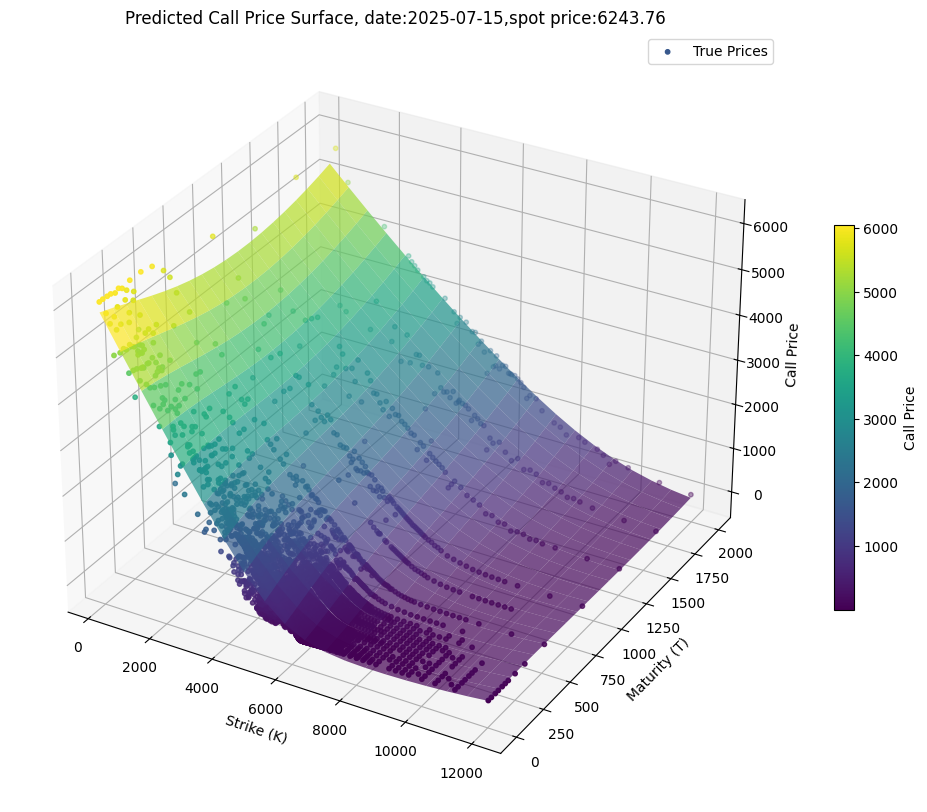

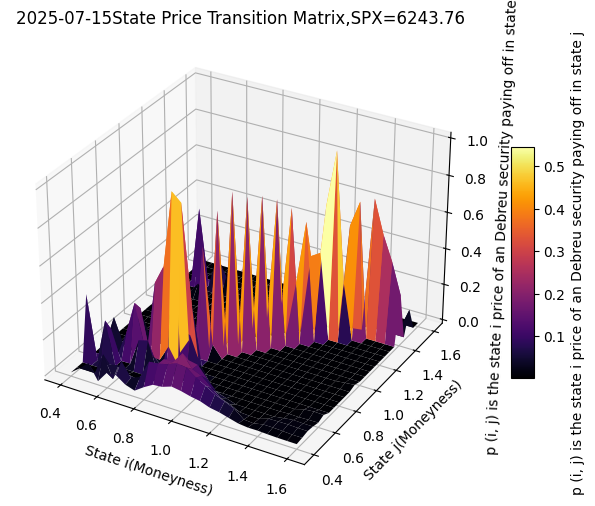

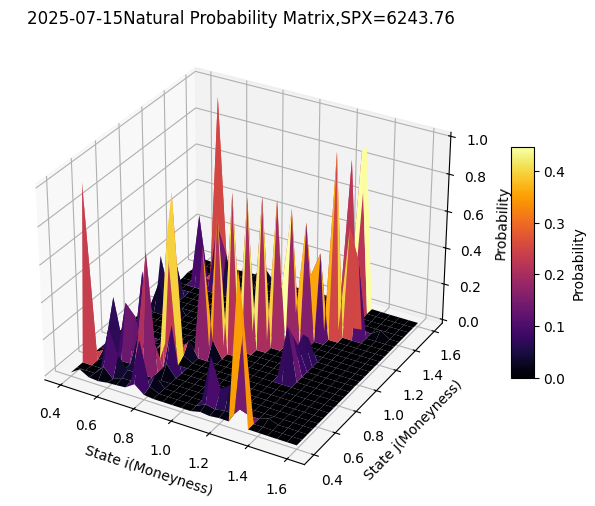

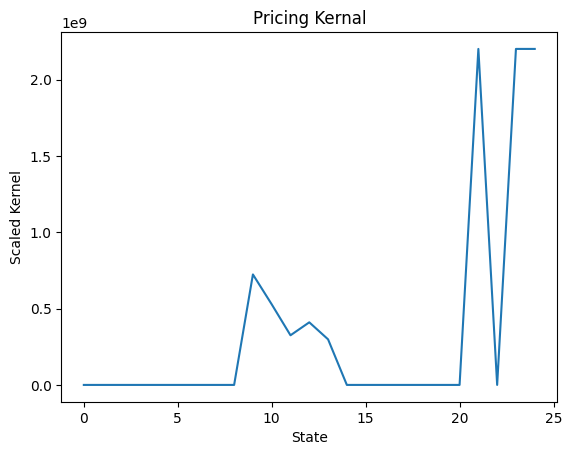

In [29]:
import os
for DATE in DATE_LIST[:1]:
  DATA_PATH = f'/content/drive/My Drive/CapstoneProject/NewCodeYfinance/Data'
  # Result Path
  PATH = f'/content/drive/My Drive/CapstoneProject/NewCodeYfinance/Result/{DATE}'
  if not os.path.exists(PATH):
      os.makedirs(PATH)

  # Load Data
  temp_df = pd.read_csv(DATA_PATH+f'/{DATE}spx_call_options.csv')
  temp_df["expirationDate"]= pd.to_datetime(temp_df["expirationDate"])
  date = pd.to_datetime(DATE)
  temp_df['T'] = (temp_df["expirationDate"]-date).dt.days
  temp_df.rename(columns = {"strike":"K", "lastPrice":'price'}, inplace = True)
  DF = temp_df[(temp_df['openInterest'] >= 1) | (temp_df['volume'] >= 1)]


  # Get spot price at date
  SPOT_PRICE = round(get_current_spot_price(DATE),2)
  # Get yield curve
  df_discount = build_discount_df(target_date=DATE)
  # Train the model
  model, train_loader = full_train(DF, epochs=130)

  # Calculate State Price Matrix
  RawState = raw_state_price(model_used=model, delta_percent=0.05,
                             train_loader=train_loader, spot_price=SPOT_PRICE)
  # Calculate Normalized State Prcie Matrix and Save
  NormState = state_price_matrix(df_discount=df_discount,
                                 pivot_table=RawState, path=PATH, date=DATE)
  # Calculate the State Price Transition Matrix
  TransState = Transition_Matrix(spot_price=SPOT_PRICE, df_rename=NormState,
                                 path=PATH, date=DATE)



  # Calculate the Natrual Probability and Phi
  NaturalMatrix, phi, delta= natural_probability(TransState, path=PATH, date=DATE)
  # Save the Graph
  surface_plot(DF, model, path=PATH, date=DATE, faxis=None, saxis=None,
               train_loader=train_loader, spot_price=SPOT_PRICE)
  psf(TransState, f"{DATE}State Price Transition Matrix,SPX={SPOT_PRICE}",
      "inferno", z_label='p (i, j) is the state i price of an Debreu security paying off in state j', path=PATH, date=DATE, file_name='TransitionSurface')

  psf(NaturalMatrix, f"{DATE}Natural Probability Matrix,SPX={SPOT_PRICE}","inferno",
      z_label='Probability', path=PATH, date=DATE, file_name='NaturalProbability')

  # plot phi and sav
  plt.figure()
  plt.plot(phi)
  plt.title("Pricing Kernal")
  plt.xlabel("State")
  plt.ylabel("Scaled Kernel")
  plt.savefig(PATH + f'/{DATE}PricingKernal.png')
  plt.show()
  plt.close()


  # psf(phi, f"{DATE}Pricing Kernal,SPX={SPOT_PRICE}","inferno", z_label='phi',
  #     path=PATH, date=DATE, file_name='PricingKernal')
